#  Learning PyMC3

Loading BokehJS ...


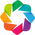

In [33]:
import pymc3 as pm
import theano
import numpy as np
import pandas as pd
import multiprocessing as mp
import bokeh.io
import bokeh.plotting
import holoviews as hv
import scipy.stats
import corner
import matplotlib.pyplot as plt
bokeh.io.output_notebook()
hv.extension('bokeh')

The goal of this notebook is to become more familiar with PyMC3. To do so, I'm working through some of the documentation on the [PyMC3](http://docs.pymc.io) website and will try to re-analyze some of the `mwc_induction` data to see if I can get the same results.  

##  Documentation Example - Linear Regression

We want to predicting outcomes $Y$ as some normally-distributed observation with an expectation value of $\mu$ that is a linear function of two predictor variables, $X_1$ and $X_2$,

$$
\begin{align}
Y &\sim \text{Normal}(\mu, \sigma^2)\\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2.
\end{align}
$$

We can assign normally-distributed priors for $\alpha$ and $\beta_i$ with a mean of zero and a half-normal distribution for $\sigma$. 

### Generating fake data

In [3]:
# Generate linearlly related data with some known seed parameters. 
alpha = 1
sigma = 1
beta_1, beta_2 = [1, 2.5]

# Set the size of the data set. 
data_size = 10000

# Determine the two predictor variables. 
X_1 = np.random.randn(data_size)
X_2 = np.random.randn(data_size) * 0.4

# Simulate the outcome variable. 
Y = alpha + beta_1 * X_1 + beta_2 * X_2 +\
    np.random.randn(data_size) * sigma

# Plot the result
p = bokeh.plotting.figure(x_axis_label='X_i', y_axis_label='Y')
p.scatter(X_1, Y, color='dodgerblue', alpha=0.1, legend='X 1')
p.scatter(X_2, Y, color='tomato', alpha=0.1, legend='X 2')

bokeh.io.show(p)

### Specifying the model

Specifying the model is relatively easy as the syntax closely resembles the statistical notation. 


In [4]:
basic_model = pm.Model()
with basic_model:
    # Set the priors. 
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_1 = pm.Normal('beta_1', mu=0, sd=10)
    beta_2 = pm.Normal('beta_2', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # Compute the expected value of the outcome. 
    mu = alpha + beta_1 * X_1 + beta_2 * X_2
    
    # Compute the likelihood of the observations. 
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

We can now find the MAP estimate for `basic_model` using numerical optimization methods.  

In [5]:
map_estimate = pm.find_MAP(model=basic_model)
print(map_estimate)

Optimization terminated successfully.
         Current function value: 14213.210621
         Iterations: 17
         Function evaluations: 24
         Gradient evaluations: 24
{'alpha': array(1.00363541308301), 'beta_1': array(1.007174352646725), 'beta_2': array(2.4703230593373666), 'sigma_log_': array(0.00133929625844894)}


Now we can just sample using NUTS. 

In [6]:
with basic_model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -14,227: 100%|██████████| 200000/200000 [01:05<00:00, 3071.99it/s]
Finished [100%]: Average ELBO = -14,227
INFO:pymc3:Finished [100%]: Average ELBO = -14,227
100%|██████████| 5000/5000 [00:20<00:00, 241.34it/s]


In [7]:
def traceframe(trace):
    keys = trace[0].keys() 
    df = pd.DataFrame([], columns=keys) 
    for t in trace:
        _df = pd.DataFrame([t])
        df = df.append(_df)
    df.drop('sigma_log_', inplace=True, axis=1)
    return df

In [8]:
df = traceframe(trace)
df.head()

,alpha,beta_1,beta_2,sigma
0,1.009361,0.990819,2.399338,1.002915
0,1.009361,0.990819,2.399338,1.002915
0,1.001600,1.023255,2.494067,0.999213
0,1.016269,0.997620,2.464131,1.004485
0,0.996156,1.013659,2.479505,1.000433


/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


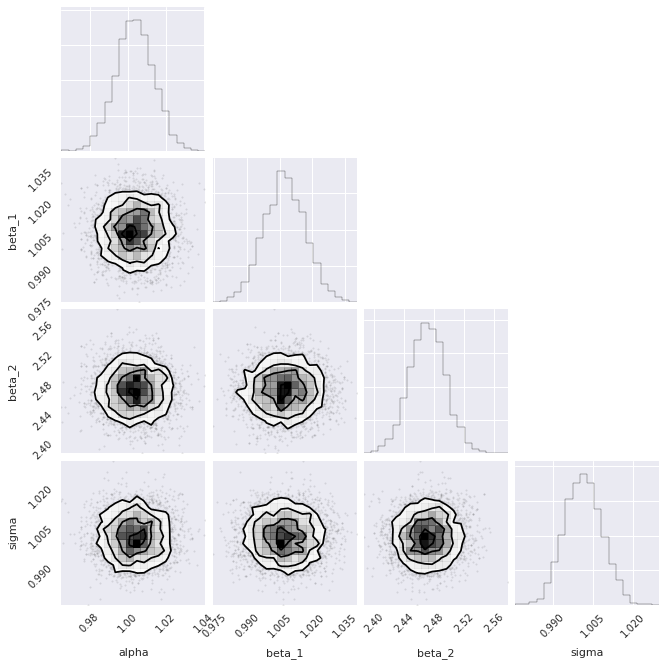

In [9]:
corner.corner(df)

##  Re-analyzing the MWC data.

In [42]:
def pact(c_range, ep_ai, ep_a, ep_i):
    numer = (1 + c_range * np.exp(-ep_a))**2
    denom = numer + np.exp(-ep_ai) * (1 + c_range * np.exp(-ep_i))**2
    return numer/denom

def fc(ep_a, ep_i, R, ep_r, c_range, ep_ai):
    p_act = pact(c_range, ep_ai, ep_a, ep_i)
    return (1 + p_act * (R /  4.6e6) * np.exp(-ep_r))**-1


In [43]:
# Load the data set. 
data = pd.read_csv('mwc_flow_master.csv')
data = pd.DataFrame(data[(data['operator']=='O2') & (data['rbs']=='RBS1027')])

In [44]:
p = bokeh.plotting.figure(plot_width=800, x_axis_type='log', x_axis_label='IPTG (µM)',
                         y_axis_label='fold-change')
p.circle(x='IPTG_uM', y='fold_change_A', source=data)
bokeh.io.show(p)

In [45]:
def Jeffreys(name):
    def theano_value(value):
        return -theano.tensor.log(value) 
    return pm.DensityDist(name, theano_value,  testval=1)

In [56]:
# Define the model. 
induction = pm.Model()
with induction:
    # Set the priors. 
    ep_a = pm.Normal('ep_a', mu=-np.log(139), sd=10)
    ep_i = pm.Normal('ep_i', mu=-np.log(0.5), sd=10)
    ep_r = pm.Normal('ep_r', mu=-13.9, sd=10)
    R = pm.Normal('R', mu=260, sd=10)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # Compute the expected value of the outcome. 
    foldchange = fc(ep_a, ep_i, R, ep_r, data['IPTG_uM'].values, 4.5)
    
    # Compute the likelihood of the observations. 
    fc_obs = pm.Normal('fc_obs', mu=foldchange, sd=sigma, observed=data['fold_change_A'].values)

In [ ]:
n_cores = mp.cpu_count()
with induction:
    trace = pm.sample(500, njobs=1)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -45.981: 100%|██████████| 200000/200000 [00:31<00:00, 6422.59it/s]
Finished [100%]: Average ELBO = -44.221
INFO:pymc3:Finished [100%]: Average ELBO = -44.221


In [ ]:
df = traceframe(trace)
df['k_a'] = np.exp(df['ep_a'])
df['k_i'] = np.exp(df['ep_i'])

In [ ]:
corner.corner(df)